<center>Clarissa Faith C. Santiago</center>
<center>DS150-BM9</center>

# <center> Houston Temperature Prediction </center>

The dataset contains 5 years of hourly temperature measurements collected from 30 cities across the US and Canada, along with 6 cities in Israel. For this project, we will only deal with the City of <b>Houston</b> and predict its temperature for the next 6 months.

---

## Data Exploration

- #### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pmdarima as pm
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("C:/Users/Faith/Downloads/temperature.csv")

- #### Converting the 'datetime' column to a DateTime format:

In [3]:
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)

In [4]:
df['Houston'].head()

datetime
2012-10-01 12:00:00           NaN
2012-10-01 13:00:00    288.270000
2012-10-01 14:00:00    288.297576
2012-10-01 15:00:00    288.334343
2012-10-01 16:00:00    288.371111
Name: Houston, dtype: float64

In [5]:
df['Houston'].tail()

datetime
2017-11-29 20:00:00    295.15
2017-11-29 21:00:00    295.82
2017-11-29 22:00:00    296.37
2017-11-29 23:00:00    294.65
2017-11-30 00:00:00    291.44
Name: Houston, dtype: float64

---

## Feature Engineering

- #### Handling Missing Values

In [6]:
# Check for missing values in the Houston column
missing_values = df['Houston'].isnull().sum()
print(f"Missing values in Houston column: {missing_values}")

Missing values in Houston column: 3


In [7]:
# Handle missing values in 'Houston' column using interpolation and fill methods
if df['Houston'].isnull().sum() > 0:
    print(f"Missing values in 'Houston' before handling: {df['Houston'].isnull().sum()}")

    # Linear interpolation
    df['Houston'] = df['Houston'].interpolate(method='linear', limit_direction='both')

    # Forward fill and backward fill for any edge cases
    df['Houston'] = df['Houston'].fillna(method='ffill').fillna(method='bfill')

    print(f"Missing values in 'Houston' after handling: {df['Houston'].isnull().sum()}")

Missing values in 'Houston' before handling: 3
Missing values in 'Houston' after handling: 0


- #### Grouping Data to Months

In [8]:
# Extract the Houston temperature data
houston_temp = df['Houston']

# Houston monthly frequency data
data_monthly = houston_temp.resample('M').mean()

---

## Exploratory Data Analysis (EDA)

> ### Monthly Average Temperature in Houston
> <ul> From the graph, there is a clear seasonality and no significant trend in temperature in Houston. </ul>

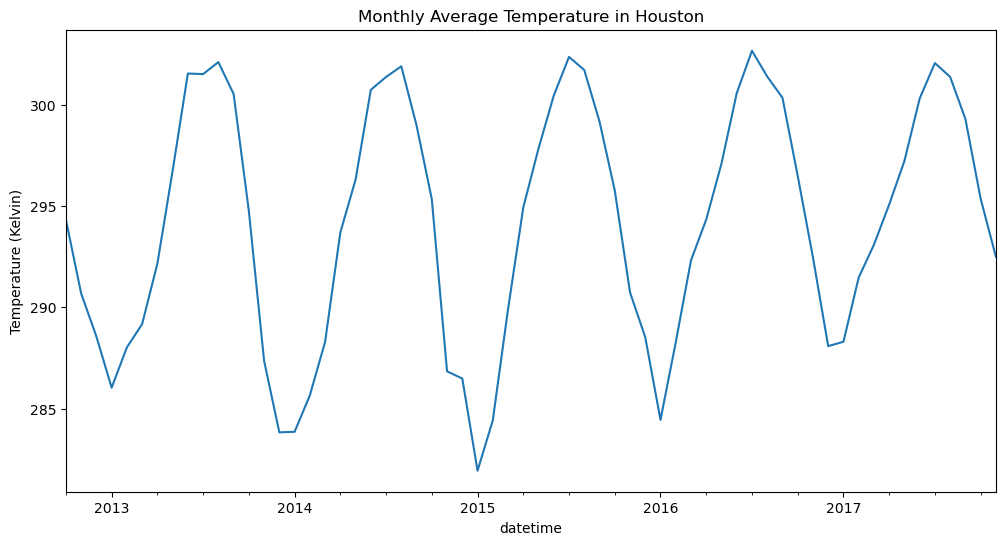

In [9]:
data_monthly.plot(figsize=(12, 6))
plt.title("Monthly Average Temperature in Houston")
plt.ylabel("Temperature (Kelvin)")
plt.show()

> ### Monthly Average Temperature in Houston (by Months)
> <ul> The bar chart below shows the average monthly temperature in Houston by months. <b>July</b> has the <i><b>highest average temperature</b></i> at 301.98 K, indicating the peak of summer in Houston, while <b>January</b> has the <i><b>lowest average temperature</b></i> at 284.92 K, reflecting the peak of winter season in Houston. </ul>

The month with the highest average temperature is: July (301.98 K)
The month with the lowest average temperature is: January (284.92 K)


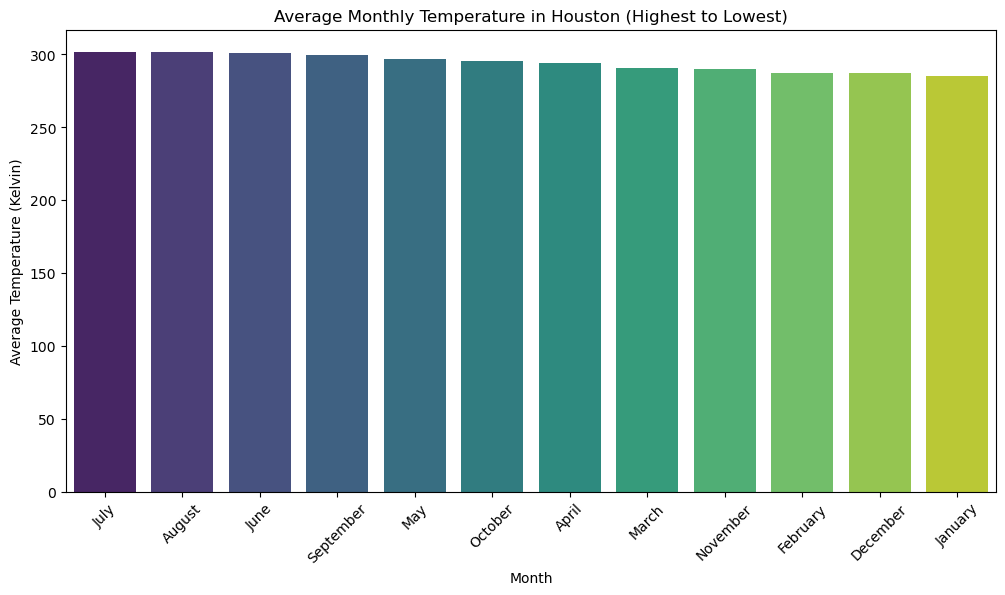

In [10]:
# Resample to monthly frequency (average for each month)
monthly_avg_temp = df['Houston'].resample('M').mean()

# Extract month numbers
month_numbers = monthly_avg_temp.index.month

# Compute average temperature per month
monthly_avg_temp_df = pd.DataFrame({'Month': month_numbers, 'AvgTemp': monthly_avg_temp.values})

# Group by month and compute the mean, then sort from highest to lowest
sorted_months = monthly_avg_temp_df.groupby('Month')['AvgTemp'].mean().sort_values(ascending=False)

# Map month numbers to names
month_names = {
    1: 'January', 2: 'February', 3: 'March', 4: 'April',
    5: 'May', 6: 'June', 7: 'July', 8: 'August',
    9: 'September', 10: 'October', 11: 'November', 12: 'December'
}

# Get highest and lowest temperature months and their average temperatures
highest_temp_month = month_names[sorted_months.index[0]]
lowest_temp_month = month_names[sorted_months.index[-1]]
highest_temp_value = sorted_months.iloc[0]  # Highest avg temperature 
lowest_temp_value = sorted_months.iloc[-1]  # Lowest avg temperature

# Display results
print(f"The month with the highest average temperature is: {highest_temp_month} ({highest_temp_value:.2f} K)")
print(f"The month with the lowest average temperature is: {lowest_temp_month} ({lowest_temp_value:.2f} K)")

plt.figure(figsize=(12, 6))
sns.barplot(x=[month_names[month] for month in sorted_months.index], 
            y=sorted_months.values, 
            palette="viridis")

plt.xlabel("Month")
plt.ylabel("Average Temperature (Kelvin)")
plt.title("Average Monthly Temperature in Houston (Highest to Lowest)")
plt.xticks(rotation=45)
plt.show()

---

## ADF (Augmented Dickey-Fuller Test) 

The Augmented Dickey-Fuller (ADF) test is a statistical test used to check if a time series is stationary. A stationary time series has statistical properties like mean and variance that do not change over time, which is essential for many forecasting models like ARIMA to work effectively. The ADF test helps determine if we need to transform or differ the data to make it stationary.

- The <b>Null Hypothesis</b> states that the time series is <b>not stationary.</b>
- The <b>Alternative Hypothesis</b> states that the time series is <b>stationary.</b>

In [11]:
# ADF Test for Stationarity before differencing
result = adfuller(data_monthly.dropna())
print("ADF Statistic:", result[0])
print("p-value:", result[1])
if result[1] > 0.05:
    print("The series is non-stationary. Differencing is required.")
else:
    print("The series is stationary.")

ADF Statistic: -0.044730573101710344
p-value: 0.9546728311311605
The series is non-stationary. Differencing is required.


- <b>ADF Statistic:</b> This is the calculated test statistic that is compared to critical values to determine whether the time series is stationary. For this analysis, the decision to reject or not reject the null hypothesis can be evaluated using the commonly referenced 5% level unless stated otherwise. In this case, our calculated ADF Statistic of approximately -0.045 is greater than the 5% critical value of -2.89, which means that we fail to reject the null hypothesis.
- <b>p-value:</b> A p-value greater than 0.05 means we fail to reject the null hypothesis. Since our p-value of approximately 0.95 is greater than 0.05, we fail to reject the null hypothesis.

<i><center>The key outputs of the ADF test confirms that <b>the series is not stationary.</b></center></i>

For this, we need to difference the data to make it stationary before building our forecasting model.

In [12]:
# Differencing to make the series stationary
data_diff = data_monthly.diff().dropna()

---

## ACF and PACF Plots

The <b>ACF plot</b> measures the correlation of the time series with its past values. The <b>PACF plot</b> measures the direct correlation of a time series with its past values, excluding the influence of intermediate lags.

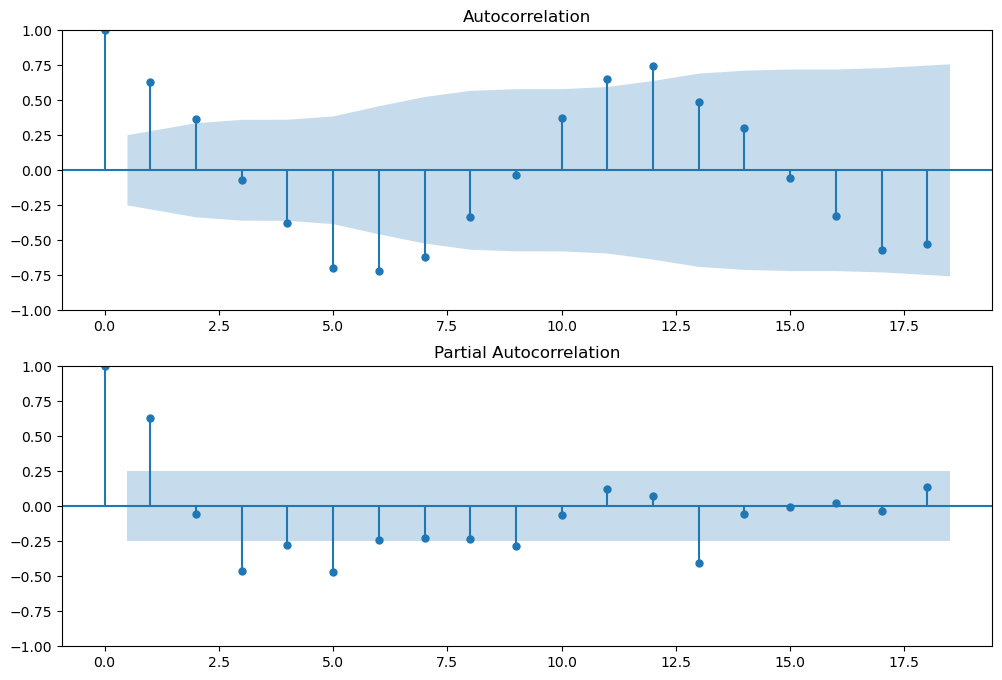

In [13]:
# Plot ACF and PACF
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(data_diff, ax=ax[0])
plot_pacf(data_diff, ax=ax[1])
plt.show()

- <b>ACF:</b> The ACF plot shows a significant drop-off at <i>lag 3</i>, indicating that the series exhibits autocorrelation up to this point. The first few lags show significant positive autocorrelation, which suggests strong seasonality or trend in the data.
- <b>PACF:</b> The PACF plot has a cutoff at <i>lag 2</i>. There are a few significant spikes at other lags, but they diminish quickly, supporting a low-order autoregressive model.

---

## ARIMA Model

ARIMA (AutoRegressive Integrated Moving Average) is a statistical model used for analyzing and forecasting time series data. It predicts future values based on past observations by identifying patterns and trends. In this analysis, we will use two approaches: <b>Auto-ARIMA</b>, which automatically selects the best model parameters, and <b>manual ARIMA</b>, where parameters are chosen based on analysis.

### 1. <b>Auto-ARIMA</b> 
- `auto_arima` automates the process of <b>selecting the best (p, d, q) parameters for ARIMA.</b>
It evaluates multiple ARIMA models and chooses the one with the <b>lowest AIC</b> (Akaike Information Criterion), which balances accuracy and model complexity. It saves time and removes the need for manual trial-and-error and <b>reduces the risk of overfitting or underfitting by selecting optimal parameters.</b> In this case, setting `seasonal=True, m=12` ensures that the model considers seasonal patterns.

In [14]:
# Use pmdarima's auto_arima to automatically find the best ARIMA parameters
auto_model = pm.auto_arima(data_diff, seasonal=True, m=12, stepwise=True, trace=True)
print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=inf, Time=0.58 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=199.466, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=197.992, Time=0.07 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=191.174, Time=0.11 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=197.467, Time=0.01 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=191.055, Time=0.05 sec
 ARIMA(0,0,1)(1,1,0)[12] intercept   : AIC=192.730, Time=0.08 sec
 ARIMA(0,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,0,2)(0,1,0)[12] intercept   : AIC=190.718, Time=0.05 sec
 ARIMA(0,0,2)(1,1,0)[12] intercept   : AIC=192.608, Time=0.10 sec
 ARIMA(0,0,2)(0,1,1)[12] intercept   : AIC=191.755, Time=0.10 sec
 ARIMA(0,0,2)(1,1,1)[12] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(1,0,2)(0,1,0)[12] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(0,0,3)(0,1,0)[12] intercept   : AIC=192.400, T

- This step trains the ARIMA model using the best parameters found by `auto_arima.`:

In [15]:
# Fit the best ARIMA model found by auto_arima
auto_arima_model = ARIMA(data_diff, order=auto_model.order)
auto_arima_result = auto_arima_model.fit()

### 6-month Temperature Forecast for Houston (Auto-ARIMA)

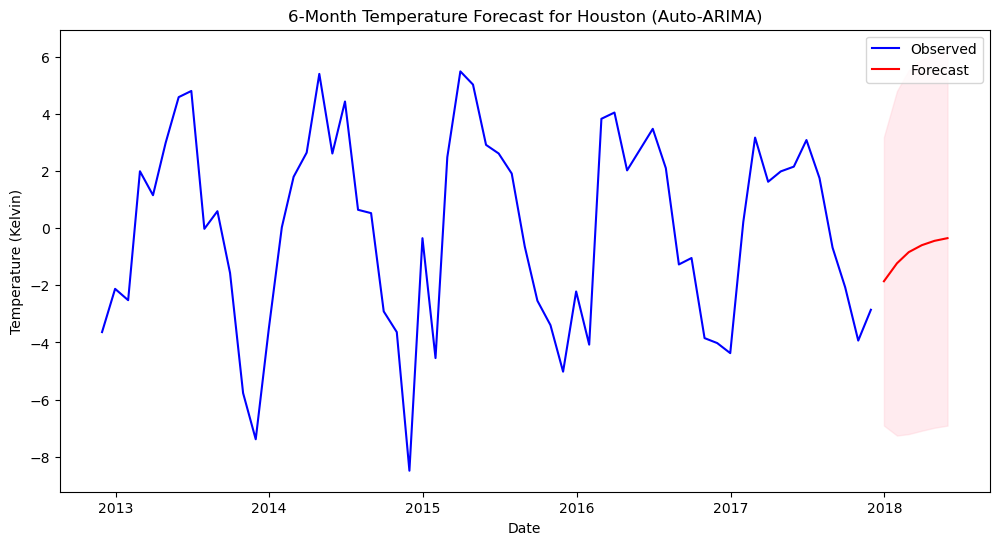

In [16]:
# Forecasting the next 6 months
forecast = auto_arima_result.get_forecast(steps=6)
forecast_index = pd.date_range(start=data_diff.index[-1], periods=7, freq='M')[1:]
forecast_mean = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

plt.figure(figsize=(12, 6))
plt.plot(data_diff, label='Observed', color='blue')
plt.plot(forecast_index, forecast_mean, label='Forecast', color='red')
plt.fill_between(forecast_index, 
                 forecast_conf_int.iloc[:, 0], 
                 forecast_conf_int.iloc[:, 1], 
                 color='pink', alpha=0.3)
plt.title("6-Month Temperature Forecast for Houston (Auto-ARIMA)")
plt.xlabel("Date")
plt.ylabel("Temperature (Kelvin)")
plt.legend()
plt.show()

The observed data shows clear seasonality, with temperature fluctuations repeating over the years. The forecast plot follows an increasing trend, suggesting a gradual rise in temperature over the next six months. The shaded pink region represents the confidence interval or uncertainty range, which widens over time and is expected since predictions become less certain as the forecast horizon increases. The ARIMA model has captured the general seasonal pattern, but the forecast appears smoother than the observed data, which could indicate that the model underestimates variability in temperature changes.

The Auto-ARIMA model provides a reasonable temperature forecast for Houston, capturing the overall trend but possibly smoothing out short-term fluctuations. The confidence interval highlights forecast uncertainty, which increases over time.

### Error Metrics ( Auto-ARIMA)

In [17]:
# Evaluate Model Performance through Error Metrics
auto_arima_forecast_values = forecast_mean.values
auto_arima_actual_values = data_diff[-6:].values

if len(auto_arima_actual_values) > 0:
    mse = mean_squared_error(auto_arima_actual_values, auto_arima_forecast_values[:len(auto_arima_actual_values)])
    mae = mean_absolute_error(auto_arima_actual_values, auto_arima_forecast_values[:len(auto_arima_actual_values)])
    rmse = np.sqrt(mse)
    
    print("Mean Absolute Error (MAE):", mae)
    print("Mean Squared Error (MSE):", mse)
    print("Root Mean Squared Error (RMSE):", rmse)
else:
    print("Not enough actual data for evaluation.")

Mean Absolute Error (MAE): 2.5912542848453985
Mean Squared Error (MSE): 8.988619775932019
Root Mean Squared Error (RMSE): 2.998102696028276


- <b>MAE:</b> On average, the model's predictions are off by about 2.59 Kelvin from the actual temperature.
- <b>MSE:</b> MSE of 8.99 reflects the squared differences between predicted and actual values, emphasizing larger errors more heavily.
- <b>RMSE:</b> Similar to MAE but gives higher weight to larger errors. A lower RMSE suggests better performance, but 2.99 still indicates some variation in predictions.

---

### 2. <b>ARIMA</b> 
- Unlike Auto-ARIMA which automatically selects the best parameters using statistical techniques, <b>ARIMA model was selected manually based on the ACF/PACF plots.</b>

In the ARIMA model, the parameters were chosen based on the ACF and PACF plots. `p = 2` was selected because the PACF plot showed a significant cutoff at lag 2, indicating that an AR(2) process was appropriate. `d = 0` was set since the data was already differenced to achieve stationarity, so further differencing was unnecessary. `q = 3` was chosen based on the ACF plot, which exhibited a significant cutoff at lag 3, suggesting that a MA(3) process effectively captures the residual autocorrelations.

In [18]:
# ARIMA Model
arima_model = ARIMA(data_diff, order=(2, 0, 3)) 
arima_result = arima_model.fit()
print(arima_result.summary())

                               SARIMAX Results                                
Dep. Variable:                Houston   No. Observations:                   61
Model:                 ARIMA(2, 0, 3)   Log Likelihood                -108.512
Date:                Sat, 08 Feb 2025   AIC                            231.024
Time:                        15:18:07   BIC                            245.800
Sample:                    11-30-2012   HQIC                           236.815
                         - 11-30-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0211      0.042      0.506      0.613      -0.061       0.103
ar.L1          1.7264      0.012    147.088      0.000       1.703       1.749
ar.L2         -0.9915      0.011    -87.102      0.0

### 6-month Temperature Forecast for Houston (ARIMA)

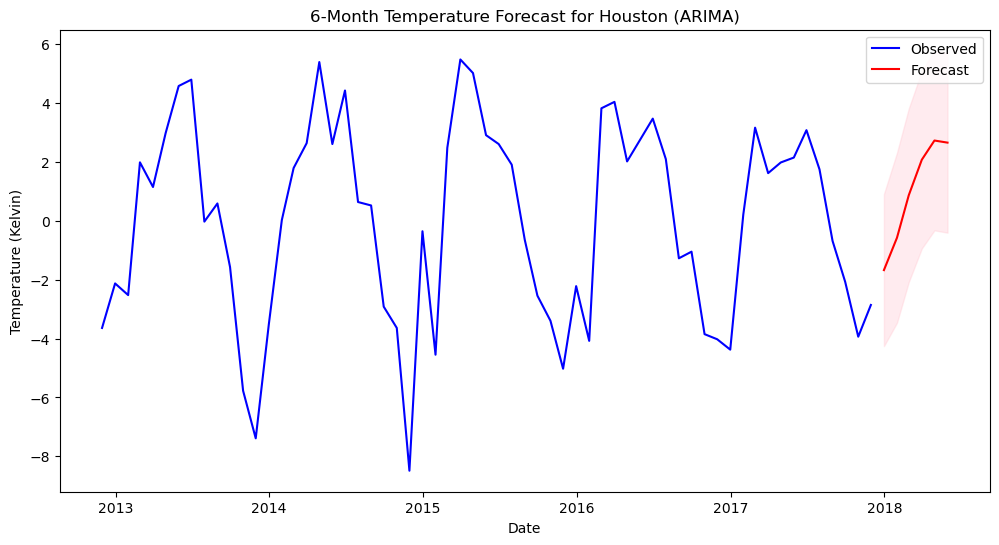

In [19]:
# Forecasting the next 6 months
forecast = arima_result.get_forecast(steps=6)
forecast_index = pd.date_range(start=data_diff.index[-1], periods=7, freq='M')[1:]
forecast_mean = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

plt.figure(figsize=(12, 6))
plt.plot(data_diff, label='Observed', color='blue')
plt.plot(forecast_index, forecast_mean, label='Forecast', color='red')
plt.fill_between(forecast_index, 
                 forecast_conf_int.iloc[:, 0], 
                 forecast_conf_int.iloc[:, 1], 
                 color='pink', alpha=0.3)
plt.title("6-Month Temperature Forecast for Houston (ARIMA)")
plt.xlabel("Date")
plt.ylabel("Temperature (Kelvin)")
plt.legend()
plt.show()

The historical temperature trend shows high variability with frequent fluctuations, indicating seasonal and irregular components in the data. The ARIMA model predicts the next 6 months, displaying a gradual upward trend. The forecast shows smoother variations compared to historical data, possibly due to the ARIMA model capturing the underlying trend while filtering out high-frequency fluctuations.The model is more confident in short-term predictions, but as time progresses, the prediction intervals widen, reflecting uncertainty in future temperature variations.

The ARIMA model captures general temperature trends well, but may oversmooth sharp variations present in historical data. The forecast suggests a rising trend in temperature, which aligns with past seasonal behaviors. However, the uncertainty increases over time, reinforcing the need for continuous model updates with new data.

### Error Metrics (ARIMA)

In [20]:
# Evaluate Model Performance through Error Metrics
arima_forecast_values = forecast_mean.values
arima_actual_values = data_diff[-6:].values if len(data_diff) >= 6 else []

if len(arima_actual_values) > 0:
    mse = mean_squared_error(arima_actual_values, arima_forecast_values[:len(arima_actual_values)])
    mae = mean_absolute_error(arima_actual_values, arima_forecast_values[:len(arima_actual_values)])
    rmse = np.sqrt(mse)
    
    print("Mean Absolute Error (MAE):", mae)
    print("Mean Squared Error (MSE):", mse)
    print("Root Mean Squared Error (RMSE):", rmse)
else:
    print("Not enough actual data for evaluation.")

Mean Absolute Error (MAE): 4.159278881051634
Mean Squared Error (MSE): 20.405770451669056
Root Mean Squared Error (RMSE): 4.517274670824109


- <b>MAE:</b> On average, the ARIMA model's predictions deviate by about 4.16 Kelvin from the actual temperature values. This value suggests moderate forecast accuracy, meaning there is room for improvement.
- <b>MSE:</b> Since errors are squared, large deviations contribute significantly to this value. A high MSE suggests that some predictions are significantly off, possibly due to extreme temperature fluctuations.
- <b>RMSE:</b> A higher RMSE compared to MAE suggests that the model struggles with large spikes or sudden changes in temperature. An RMSE of 4.52 K means that, on average, predictions will be off by about 4.52 K.

---

## Conclusion

The ARIMA model captures short-term fluctuations well, but its forecast shows noticeable deviations from actual values, reflected in higher error metrics. This suggests that while it follows patterns effectively, it struggles with extreme variations. On the other hand, Auto-ARIMA optimizes parameter selection, resulting in a smoother forecast that may not capture short-term variations as accurately but achieves lower errors.

While both models provided valuable insights, <b>ARIMA is better at capturing rapid changes</b>, while <b>Auto-ARIMA provides a more generalized and stable prediction with improved accuracy.</b> Future improvements could involve incorporating additional external factors, seasonal adjustments, or experimenting with deep learning models to enhance forecast precision.